# MS029 Preprocess
Created: 01/29/2024 \
Updated: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS029'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS029/raw/MS029_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3222015  =      0.000 ...  3146.499 secs...


In [7]:
mne_data

<RawEDF | MS029_SWB.edf, 276 x 3222016 (3146.5 s), ~6.63 GB, data loaded>

In [9]:
# mne_data.ch_names

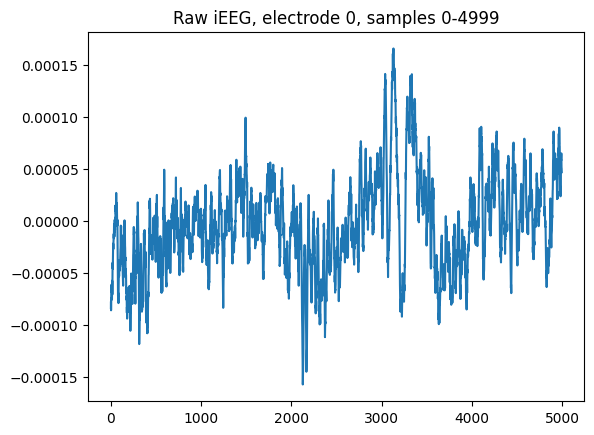

In [8]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [8]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   39.7s finished


<RawEDF | MS029_SWB.edf, 276 x 1573250 (3146.5 s), ~3.24 GB, data loaded>

### Photodiode
- examine photodiode 

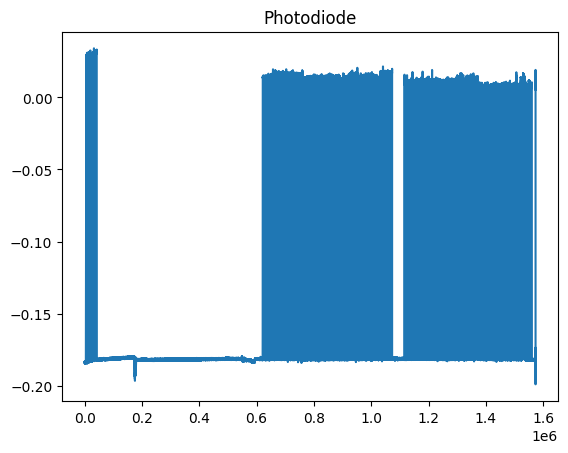

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [10]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS029/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS029/photodiode.fif
[done]


In [11]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS029_SWB.edf, 275 x 1573250 (3146.5 s), ~3.22 GB, data loaded>

### Notch filter line noise

In [12]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:   13.4s finished


<RawEDF | MS029_SWB.edf, 275 x 1573250 (3146.5 s), ~3.22 GB, data loaded>

### Anatomical Localization

In [13]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS029_SWB.edf, 275 x 1573250 (3146.5 s), ~3.22 GB, data loaded>

In [14]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A13_L,-2.995627,39.955832,-20.977326,-3.651905,29.347904,-16.284472,Gray,Left MFC medial frontal cortex,Area s32,L Rectal Gyrus,L OrG,Left frontal pole 1 B,NaN,NaN
1,LaCaS10,A9/46d_L,-17.774106,64.755819,13.785092,-19.681925,52.011306,23.786070,White,Left SFG superior frontal gyrus,Unknown,L Middle Frontal Gyrus,L MFG,Left middle frontal gyrus 2 A,WM,NaN
2,LaCaS11,A9/46d_L,-18.972361,67.955818,17.381204,-20.959194,55.023796,28.128578,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L MFG,Left middle frontal gyrus 2 A,NaN,NaN
3,LaCaS12,A9/46d_L,-20.570035,70.755816,20.178181,-22.702371,57.682280,31.549648,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L MFG,Left middle frontal gyrus 2 A,OOB,NaN
4,LaCaS2,A32sg_L,-4.593300,42.755831,-16.981645,-5.454643,31.717963,-11.494004,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L CG,Left cingulate gyrus D,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,RmOlFLes5,A11l_R,24.164821,55.155824,-14.584237,24.934669,46.527631,-8.068891,White,Right Cerebral White Matter,Unknown,Unknown,R OrG,Unknown,WM,NaN
144,RmOlFLes6,Unknown,27.360168,54.755825,-10.988125,28.684556,45.895131,-4.288050,White,Right Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
145,RmOlFLes7,Unknown,30.555515,54.755825,-6.992445,32.426271,45.690234,-0.110804,White,Right Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
146,RmOlFLes8,A9/46v_R,34.150280,54.355825,-2.996765,36.560806,45.178333,4.076871,Gray,Right Cerebral White Matter,Unknown,R Middle Frontal Gyrus,R MFG,Right anterior pars triangularis A,NaN,NaN


In [15]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT10',
 'LAglT11',
 'LAglT12',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LaIS1',
 'LaIS10',
 'LaIS11',
 'LaIS12',
 'LaIS13',
 'LaIS14',
 'LaIS15',
 'LaIS16',
 'LaIS2',
 'LaIS3',
 'LaIS4',
 'LaIS5',
 'LaIS6',
 'LaIS7',
 'LaIS8',
 'LaIS9',
 'LHph1',
 'LHph10',
 'LHph2',
 'LHph3',
 'LHph4',
 'LHph5',
 'LHph6',
 'LHph7',
 'LHph8',
 'LHph9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RAglT1',
 'RAglT10',
 'RAglT11',
 'RAglT12',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 

In [16]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['rmolf1', 'rmolf2', 'rmolf3', 'rmolf4', 'rmolf5', 'rmolf6', 'rmolf7', 'rmolf8', 'rmolf9', 'rmolf10', 'rmolf11', 'rmolf12', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'lals1', 'lals2', 'lals3', 'lals4', 'lals5', 'lals6', 'lals7', 'lals8', 'lals9', 'lals10', 'lals11', 'lals12', 'lals13', 'lals14', 'lals15', 'lals16', 'rals1', 'rals2', 'rals3', 'rals4', 'rals5', 'rals6', 'rals7', 'rals8', 'rals9', 'rals10', 'rals11', 'rals12', 'rals13', 'rals14', 'rals15', 'rals16', 'lagit1', 'lagit2', 'lagit3', 'lagit4', 'lagit5', 'lagit6', 'lagit7', 'lagit8', 'lagit9', 'lagit10', 'lagit11', 'lagit12', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'ragit1', 'ragit2', 'ragit3', 'ragit4', 'ragit5', 'ragit6', 'ragit7', 'ragit8', 'ragit9', 'ragit10', 'ragit11', 'ragit12', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c

In [17]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [18]:
unmatched_seeg #make sure there are no unmatched names


[]

In [19]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [20]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'lmolf10': 'lmolf10',
 'lmolf11': 'lmolf11',
 'lmolf12': 'lmolf12',
 'rmolf1': 'rmolfles1',
 'rmolf2': 'rmolfles2',
 'rmolf3': 'rmolfles3',
 'rmolf4': 'rmolfles4',
 'rmolf5': 'rmolfles5',
 'rmolf6': 'rmolfles6',
 'rmolf7': 'rmolfles7',
 'rmolf8': 'rmolfles8',
 'rmolf9': 'rmolfles9',
 'rmolf10': 'rmolfles10',
 'rmolf11': 'rmolfles11',
 'rmolf12': 'rmolfles12',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 

In [21]:
# # Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS029_SWB.edf, 275 x 1573250 (3146.5 s), ~3.22 GB, data loaded>

In [22]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 72 left sEEG and 76 right sEEG electrodes
We have a total of 148 sEEG electrodes


In [23]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS029_SWB.edf, 275 x 1573250 (3146.5 s), ~3.22 GB, data loaded>

In [24]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS029_SWB.edf, 148 x 1573250 (3146.5 s), ~1.73 GB, data loaded>

In [25]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS029_SWB.edf, 148 x 1573250 (3146.5 s), ~1.73 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [30]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [31]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [32]:
probe_ch_counts

{'lacas': 12,
 'laglt': 12,
 'lais': 16,
 'lhph': 10,
 'lmcms': 10,
 'lmolf': 12,
 'racas': 12,
 'raglt': 12,
 'rais': 16,
 'rhph': 14,
 'rmcms': 10,
 'rmolfles': 12}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [33]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lacas3',
 'laglt8',
 'lais14',
 'lhph6',
 'raglt10',
 'raglt11',
 'raglt3',
 'raglt4',
 'raglt9',
 'rhph1',
 'rhph2']

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


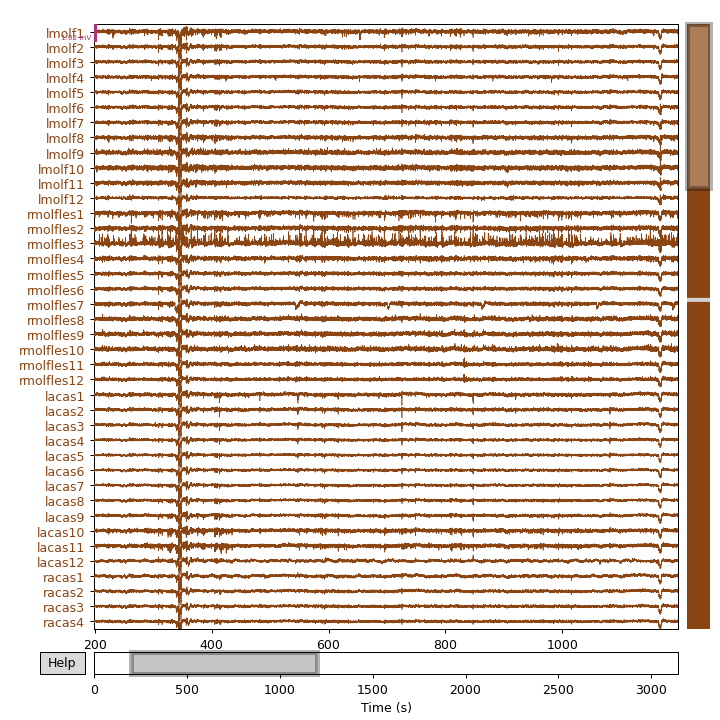

In [34]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/20)


In [27]:
mne_data.info['bads'] = ['rmcms10']

In [26]:
# mne_data.info['bads'] = ['rmolfles3',
#  'rmcms10',
#  'lais1',
#  'laglt1',
#  'lhph1',
#  'lhph2',
#  'rhph1',
#  'rhph2',
#  'laglt3',
#  'rhph3',
#  'laglt2'] # old 01/2024

In [28]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 1 items (rmcms10)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 148 sEEG
 custom_ref_applied: False
 dig: 148 items (148 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 09:13:09 UTC
 nchan: 148
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [29]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [30]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=90, n_times=1573250
    Range : 0 ... 1573249 =      0.000 ...  3146.498 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas10-lacas11, laglt1-laglt2, laglt2-laglt3, laglt3-laglt4, laglt4-laglt5, laglt5-laglt6, laglt6-laglt7, laglt8-laglt9, laglt9-laglt10, lais1-lais2, lais2-lais3, lais3-lais4, lais4-lais5, lais5-lais6, lais6-lais7, lais8-lais9, lais9-lais10, lais10-lais11, lais11-lais12, lais12-lais13, lais13-lais14, lhph1-lhph2, lhph2-lhph3, lhph3-lhph4, lhph6-lhph7, lhph7-lhph8, lhph8-lhph9, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms6-lmcms7, lmcms7-lmcms8, lmolf1-lmolf2, lmolf3-lmolf4, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, lmolf8-lmolf9, lmolf9-lmolf10, lmolf10-lmolf11, racas1-racas2, racas2-racas3, racas4-racas5, racas5-racas6, racas6-racas7, racas7-racas8, racas8-racas9, racas9-racas10, racas10-

In [31]:
mne_data_bp_reref

<RawEDF | MS029_SWB.edf, 90 x 1573250 (3146.5 s), ~1.06 GB, data loaded>

In [32]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas10-lacas11',
 'laglt1-laglt2',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt4-laglt5',
 'laglt5-laglt6',
 'laglt6-laglt7',
 'laglt8-laglt9',
 'laglt9-laglt10',
 'lais1-lais2',
 'lais2-lais3',
 'lais3-lais4',
 'lais4-lais5',
 'lais5-lais6',
 'lais6-lais7',
 'lais8-lais9',
 'lais9-lais10',
 'lais10-lais11',
 'lais11-lais12',
 'lais12-lais13',
 'lais13-lais14',
 'lhph1-lhph2',
 'lhph2-lhph3',
 'lhph3-lhph4',
 'lhph6-lhph7',
 'lhph7-lhph8',
 'lhph8-lhph9',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms6-lmcms7',
 'lmcms7-lmcms8',
 'lmolf1-lmolf2',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'lmolf9-lmolf10',
 'lmolf10-lmolf11',
 'racas1-racas2',
 'racas2-racas3',
 'racas4-racas5',
 'racas5-racas6',
 'racas6-racas7',
 'racas7-racas8',
 'racas8-racas9',
 'racas9-racas10',
 'racas10-racas11',
 'raglt3-raglt4',
 'raglt8-raglt9',
 'raglt9-r

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


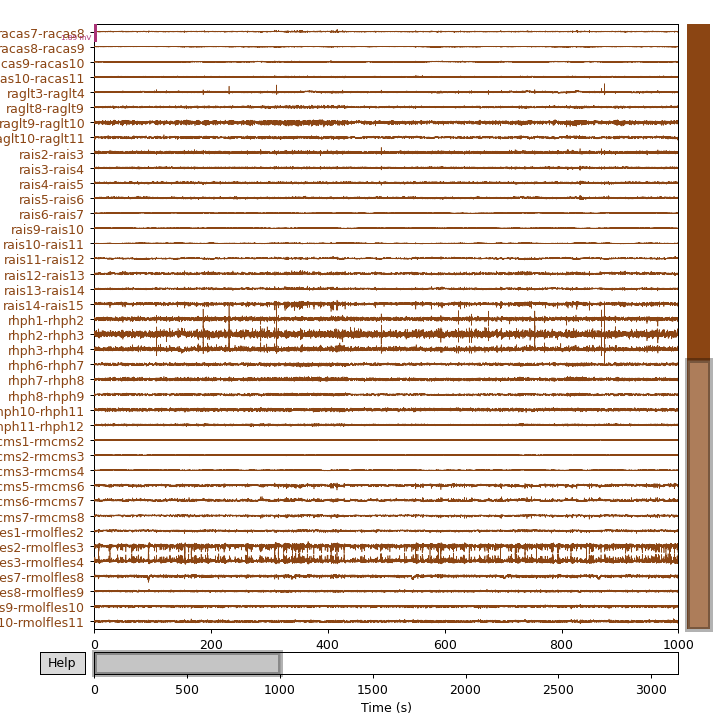

In [41]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max()/5)


Effective window size : 0.512 (s)


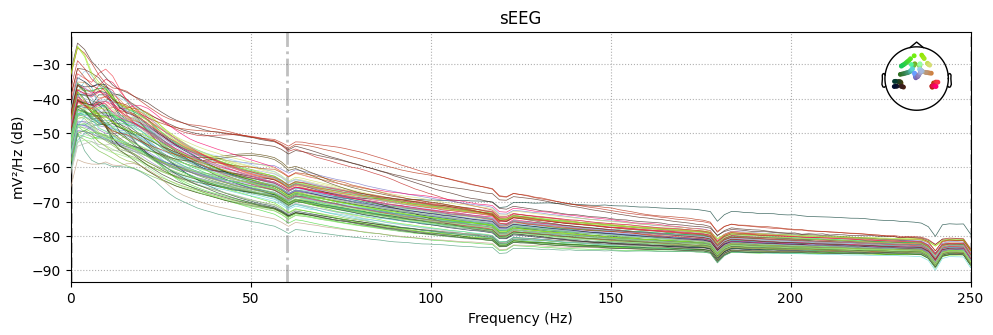

In [33]:
mne_data_bp_reref.compute_psd().plot()

In [34]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS029/bp_ref_ieeg.fif
    Writing channel names to FIF truncated to 15 characters with remapping
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS029/bp_ref_ieeg.fif
[done]


## Save mne_data

In [35]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS029/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS029/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [36]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [37]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS029/photodiode.fif...
Isotrak not found
    Range : 0 ... 1573249 =      0.000 ...  3146.498 secs
Ready.
Reading 0 ... 1573249  =      0.000 ...  3146.498 secs...


In [38]:
photodiode_data

<Raw | photodiode.fif, 1 x 1573250 (3146.5 s), ~12.0 MB, data loaded>

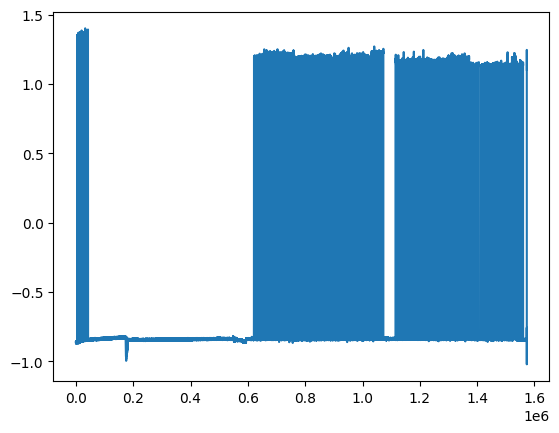

In [41]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
plt.show()

In [42]:
temp_diode = photodiode_data.copy()
temp_data = temp_diode._data[0,:]
temp_data[0:1000000] = np.min(temp_data)

temp_diode._data = temp_data

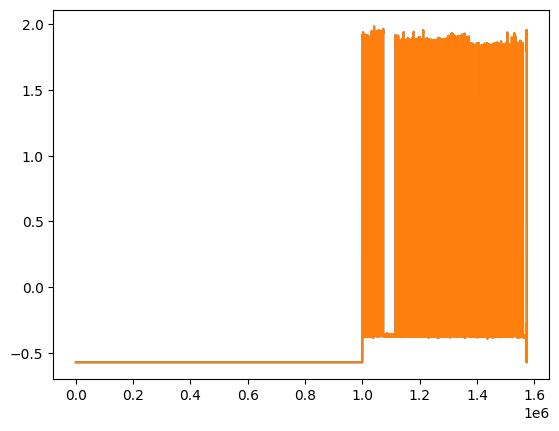

In [44]:
plt.plot(scipy.stats.zscore(temp_diode._data[:]))
plt.show()

In [69]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

6 blocks
......

found matches for 60 of 90 pulses
4 blocks
....

found matches for 60 of 90 pulses


In [70]:
print(slope, offset,smoothSize,windSize,height)

0.9999957886799461 -212.68372288365072 11 15 0.7


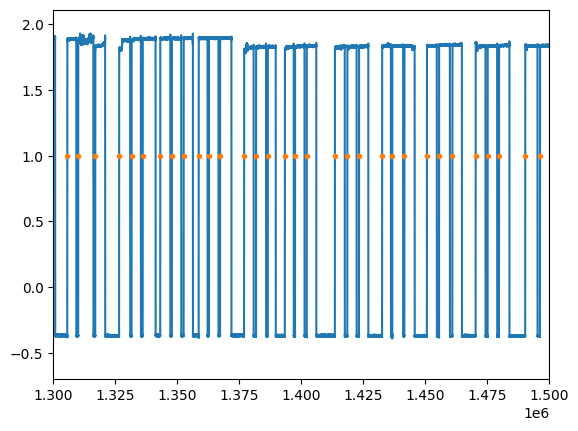

In [71]:
pulses = [(x*slope + offset) for x in beh_ts]
plt.plot(scipy.stats.zscore(temp_diode._data[:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*500, 
         np.ones_like(np.array(pulses) * photodiode_data.info['sfreq']),'.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([1300000,1500000])
# plt.ylim([5,6])
plt.show()


In [72]:
print(slope, offset,smoothSize,windSize,height)

0.9999957886799461 -212.68372288365072 11 15 0.7


In [130]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [73]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [74]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [75]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [76]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS029/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 1573249 =      0.000 ...  3146.498 secs
Ready.
Reading 0 ... 1573249  =      0.000 ...  3146.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.7s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 90 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS029/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 1573249 =      0.000 ...  3146.498 secs
Ready.
Reading 0 ... 1573249  =      0.000 ...  3146.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.4s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 90 columns


In [77]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~154.7 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~360.7 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [78]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']


In [79]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 112 columns
Replacing existing metadata with 112 columns


In [80]:
epochs_all_evs[event].metadata

,lacas1-lacas2,lacas2-lacas3,lacas3-lacas4,lacas10-lacas11,laglt1-laglt2,laglt2-laglt3,laglt3-laglt4,laglt4-laglt5,laglt5-laglt6,laglt6-laglt7,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.10,-0.10,-0.10,-0.10,0.00,0.0,0.10,0.1,0.00,0.00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.34,-0.14,-0.34,-0.14,0.00,0.0,0.00,-0.2,0.00,-0.17
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.42,-0.30,-0.42,-0.30,0.00,0.0,0.12,0.0,0.00,-0.21
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.30,0.30,0.00,0.00,0.30,0.3,0.00,0.0,0.00,0.00
4,NaN,NaN,NaN,NaN,[1342.192],NaN,NaN,NaN,NaN,NaN,...,0.36,0.20,0.00,0.00,0.36,0.2,-0.36,-0.2,0.18,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.72,0.20,0.00,0.00,0.72,0.2,-0.72,-0.2,0.36,0.00
146,NaN,noise,NaN,NaN,[3079.618],NaN,NaN,NaN,NaN,NaN,...,-2.42,-1.10,-2.42,-1.10,0.00,0.0,1.32,0.0,0.00,-1.21
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00
148,NaN,NaN,NaN,NaN,NaN,NaN,[3110.374],NaN,NaN,NaN,...,0.30,0.30,0.00,0.00,0.30,0.3,-0.30,-0.3,0.00,0.00


### Save raw epoched data 

In [81]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping


### Baseline + Decompose into TFRs

In [82]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [83]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [84]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [85]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]


temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


In [86]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 90, ~1.51 GB>}

In [87]:
power_epochs = {}

In [88]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Not setting metadata
Adding metadata with 112 columns


In [89]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 90, ~7.55 GB>

In [90]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [91]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

04082024


In [479]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

In [92]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


-212.68372288365072
